## Init

In [1]:
# feffi module lives one level up current dir
import os
if not os.path.isdir('feffi'): #if not already in right place - hacky!
    os.chdir("../") #for feffi to work

import feffi
from fenics import *
from mshr import *
import mshr
import matplotlib.pyplot as plt
import numpy as np
import itertools
import imageio

## 2D constant linear x-wise left compression with structured mesh
Run 3 steps of the Lid Driven Cavity experiment, then compress the mesh x-wise with a factor of 0.9. Need to rebuild the bounding box tree as that is not automatically done and who knows why. Run an extra timestep then.

In [ ]:
feffi.parameters.define_parameters({
    'config_file' : 'feffi/config/lid-driven-cavity.yml',
})

mesh = feffi.mesh.create_mesh()
f_spaces = feffi.functions.define_function_spaces(mesh)
f = feffi.functions.define_functions(f_spaces)
domain = feffi.boundaries.Domain(mesh, f_spaces)
simul = feffi.simulation.Simulation(f, domain.BCs)
for i in range(3):
    simul.timestep()

# Compress mesh x-wise with factor 0.9
bmesh = BoundaryMesh(mesh, "exterior")
for x in bmesh.coordinates():
    x[0] *= 0.9
ALE.move(mesh, bmesh)
mesh.bounding_box_tree().build(mesh)

simul.timestep()

feffi.plot.plot_single(f['u_'], display=True)
feffi.plot.plot_single(mesh, display=True)

## 2D repeated linear x-wise left compression (structured mesh)
Repeatedly run 1 step of the Lid Driven Cavity experiment, then compress the mesh x-wise with a factor of 0.07 and  rebuild the bounding box tree.

In [ ]:
feffi.parameters.define_parameters({
    'config_file' : 'feffi/config/lid-driven-cavity.yml',
})

# Structured mesh
mesh = UnitSquareMesh(8,8)
feffi.plot.plot_single(mesh, display=True, title="Starting mesh")

f_spaces = feffi.functions.define_function_spaces(mesh)
f = feffi.functions.define_functions(f_spaces)
domain = feffi.boundaries.Domain(mesh, f_spaces)
simul = feffi.simulation.Simulation(f, domain.BCs)

# Repeatedly run 1 timestep and deform mesh
for x in range(10):
    print("\n\nMesh hmax is {}\n".format(mesh.hmax()))
    simul.timestep()

    # 0.02 x-wise displacement
    disp = Expression(("0.07*(left-x[0])", "0"),
                      left=max(mesh.coordinates()[:,0]), degree=2)
    ALE.move(mesh, disp)

    mesh.bounding_box_tree().build(mesh)

    feffi.plot.plot_single(f['u_'], display=True)
    feffi.plot.plot_single(mesh, display=True,
                           title="Mesh with left x = {}".format(min(mesh.coordinates()[:,0])))

## 2D repeated linear x-wise left compression (UNstructured mesh)
Repeatedly run 1 step of the Lid Driven Cavity experiment, then compress the mesh x-wise with a factor of 0.07 and  rebuild the bounding box tree.

In [ ]:
feffi.parameters.define_parameters({
    'config_file' : 'feffi/config/lid-driven-cavity.yml',
})

# Unstructured mesh
points = [Point(0,0), Point(1,0), Point(1,1), Point(0,1)] # square
#points = [Point(0,0), Point(10,0), Point(10,1), Point(0,1)] # long domain
domain = Polygon(points)
mesh = generate_mesh(domain, 16, 'cgal')

feffi.plot.plot_single(mesh, display=True, title="Starting mesh")

f_spaces = feffi.functions.define_function_spaces(mesh)
f = feffi.functions.define_functions(f_spaces)
domain = feffi.boundaries.Domain(mesh, f_spaces)
simul = feffi.simulation.Simulation(f, domain.BCs)

# Repeatedly run 1 timestep and deform mesh
for x in range(10):
    print("\n\nMesh hmax is {}\n".format(mesh.hmax()))
    simul.timestep()

    # 0.02 x-wise displacement
    disp = Expression(("0.07*(left-x[0])", "0"),
                      left=max(mesh.coordinates()[:,0]), degree=2)
    ALE.move(mesh, disp)

    mesh.bounding_box_tree().build(mesh)

    feffi.plot.plot_single(f['u_'], display=True)
    feffi.plot.plot_single(mesh, display=True,
                           title="Mesh with left x = {}".format(min(mesh.coordinates()[:,0])))

## 2D pointwise x-wise left compression (structured mesh)
- Run 1 step of the Lid Driven Cavity experiment.
- Store indexes of mesh points that belong to left boundary.
- Move left boundary points x-wise, each of a different random amount, and rebuild the bounding box tree.

In [ ]:
feffi.parameters.define_parameters({
    'config_file' : 'feffi/config/lid-driven-cavity.yml',
})

# Structured mesh
mesh = UnitSquareMesh(8,8)

feffi.plot.plot_single(mesh, display=True, title="Starting mesh")

f_spaces = feffi.functions.define_function_spaces(mesh)
f = feffi.functions.define_functions(f_spaces)
domain = feffi.boundaries.Domain(mesh, f_spaces)
simul = feffi.simulation.Simulation(f, domain.BCs)

# Get indexes of mesh points that belong to left boundary.
# Once we start moving them, this information is lost.
left_idxs = []
b_mesh = BoundaryMesh(mesh, 'exterior')
for p_idx in range(len(b_mesh.coordinates())):
    if domain.boundaries['left'].inside(b_mesh.coordinates()[p_idx], True):
        left_idxs.append(p_idx)

# Repeatedly run 1 timestep and deform mesh
for x in range(2):
    print("\n\nMesh hmax is {}\n".format(mesh.hmax()))
    simul.timestep()

    import random
    b_mesh = BoundaryMesh(mesh, 'exterior')
    for p_idx in left_idxs:
        b_mesh.coordinates()[p_idx][0] += (-1)**int(random.random()*10) * random.random()/10
        ALE.move(mesh, b_mesh)

    mesh.bounding_box_tree().build(mesh)

    feffi.plot.plot_single(f['u_'], display=True)
    feffi.plot.plot_single(mesh, display=True,
                           title="Mesh with left x = {}".format(min(mesh.coordinates()[:,0])))

## 2D x-wise left deformation wrt given points list (structured mesh)


In [3]:
feffi.parameters.define_parameters({
    'config_file' : 'feffi/config/lid-driven-cavity.yml',
})
gif_filenames = []

# MESH INIT (unstructured)
points = [Point(0,0), Point(1,0), Point(1,1), Point(0,1)] # square
#points = [Point(0,0), Point(10,0), Point(10,1), Point(0,1)] # long domain
domain = Polygon(points)
mesh = generate_mesh(domain, 10, 'cgal')
#feffi.plot.plot_single(mesh, display=True, title="Starting mesh")

plot(mesh, title='Starting (ocean) mesh')
filename = 'mesh-1.png'
plt.savefig(filename, dpi=300)
plt.close()
for i in range(5):
    gif_filenames.append(filename)

# FEFFI INIT
f_spaces = feffi.functions.define_function_spaces(mesh)
f = feffi.functions.define_functions(f_spaces)
domain = feffi.boundaries.Domain(mesh, f_spaces)
simul = feffi.simulation.Simulation(f, domain.BCs)

# end idea is to call smth like
# domain.deform_boundary('top', goal_profile, n_steps)

# New "goal" left profile
# NOTE: goal profile is supposed to be COARSER than current profile
step_size = 0.1
goal_profile = [(0.5*(y-0.5)**2-0.1, y) 
         for y in np.arange(min(mesh.coordinates()[:,1]), 
                            max(mesh.coordinates()[:,1])+step_size, 
                            step_size)]
goal_profile_length = feffi.boundaries.curve_length(goal_profile)

# Current left profile
curr_profile = domain.subdomains_points['left']
curr_profile_length = feffi.boundaries.curve_length(list(curr_profile.values()))

print(('Current mesh left profile has {} vertexes, perimeter {} and coordinates \n {}\n\n'
       .format(len(curr_profile), curr_profile_length, curr_profile)))
print(('Goal mesh left profile has {} vertexes, perimeter {} and coordinates \n {}'
       .format(len(goal_profile), goal_profile_length, goal_profile)))

# Obtain the new ocean profile
goal_p_idx = 0
curr_profile_iter = itertools.cycle(list(curr_profile.items()))
curr_profile_curr_p = next(curr_profile_iter)
new_profile = {curr_profile_curr_p[0]: goal_profile[0]} # first point matches both for ice and ocean
new_profile_last_p = goal_profile[0]

# Goal mesh is supposed to be finer than current mesh.
# First task: to obtain a goal mesh of equal grane as current one.
for i in range(1, len(list(curr_profile.items()))-1):
    curr_profile_prev_p_idx = curr_profile_curr_p[0]
    curr_profile_prev_p_coord = curr_profile_curr_p[1]
    
    curr_profile_curr_p = next(curr_profile_iter)
    curr_profile_curr_p_idx = curr_profile_curr_p[0]
    curr_profile_curr_p_coord = curr_profile_curr_p[1]

    d = np.linalg.norm(np.subtract(curr_profile_curr_p_coord, curr_profile_prev_p_coord))/curr_profile_length
    direction_vector = np.subtract(goal_profile[goal_p_idx+1], new_profile_last_p)
    new_p = new_profile_last_p + np.multiply(direction_vector, d*goal_profile_length/np.linalg.norm(direction_vector))
    new_profile[curr_profile_curr_p_idx] = new_p
    
    new_profile_last_p = new_p
    if new_profile_last_p[1] >= goal_profile[goal_p_idx+1][1]: # first coord forces it to be vertical boundary
        goal_p_idx += 1

# set last point, also matching ice exactly
curr_profile_curr_p = next(curr_profile_iter)
new_profile[curr_profile_curr_p[0]] = goal_profile[-1]

# new_profile contains now the new ocean profile coming from the ice. We'll take gradual steps to reach it

total_steps = 5 # n of steps during which we want to spread the deformation out
for x in range(total_steps):
    deform_coeff = (x+1)/total_steps #how much to deform the mesh in this single t step
    
    simul.timestep() #run one ocean timestep

    # Deform boundary mesh and move whole mesh according to new boundary
    b_mesh = BoundaryMesh(mesh, 'exterior')
    for (p_idx, p_coord) in new_profile.items():
        print(('old point {} becomes {}'
              .format(b_mesh.coordinates()[p_idx],
                      (deform_coeff*new_profile[p_idx][0], 
                       new_profile[p_idx][1]))))
        
        b_mesh.coordinates()[p_idx][0] = deform_coeff*new_profile[p_idx][0]
        b_mesh.coordinates()[p_idx][1] = new_profile[p_idx][1]
        
    ALE.move(mesh, b_mesh)
    mesh.bounding_box_tree().build(mesh) # just to be sure do it every time

    plot(mesh, title='{}/{} (ocean) mesh'.format(x, total_steps))
    filename = 'mesh{}.png'.format(x)
    plt.savefig(filename, dpi=300)
    plt.close()
    if x == total_steps-1:
        for i in range(10):
            gif_filenames.append(filename)
    else:
        for i in range(3):
            gif_filenames.append(filename)

# build gif
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in gif_filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
#for filename in set(gif_filenames):
#    os.remove(filename)

[13:30:29] BCs were only given for V, Q spaces.
[13:30:29] BCs - Boundary right, space V[0] (marker 1), value 0
[13:30:29] BCs - Boundary right, space V[1] (marker 1), value 0
[13:30:29] BCs - Boundary bottom, space V[0] (marker 3), value 0
[13:30:29] BCs - Boundary bottom, space V[1] (marker 3), value 0
[13:30:29] BCs - Boundary left, space V[0] (marker 2), value 0
[13:30:29] BCs - Boundary left, space V[1] (marker 2), value 0
[13:30:29] BCs - Boundary top, space V[0] (marker 4), value 1
[13:30:29] BCs - Boundary top, space V[1] (marker 4), value 0
[13:30:29] BCs - Point (0, 0), space Q, value 0
[13:30:29] Initialized simulation.
[13:30:29] Running parameters:
{'final_time': 10000000000, 'steps_n': 10, 'simulation_precision': -5, 'degree_V': 2, 'degree_P': 1, 'degree_T': 1, 'degree_S': 1, 'convert_from_ms_to_kmh': False, 'g': 0, 'nu': [0.01], 'alpha': [1], 'rho_0': 1, 'beta': 0, 'gamma': 0, 'T_0': 1, 'S_0': 35, 'Omega_0': '-5e-5', 'domain': 'square', 'domain_size_x': 2, 'domain_size_y

boundary right oriented wrt to 1 coord
boundary left oriented wrt to 1 coord
boundary bottom oriented wrt to 0 coord
boundary top oriented wrt to 0 coord
Current mesh left profile has 17 vertexes, perimeter 1.0 and coordinates 
 {3: array([0., 0.]), 5: array([0.    , 0.0625]), 49: array([0.   , 0.125]), 26: array([0.    , 0.1875]), 24: array([0.  , 0.25]), 25: array([0.    , 0.3125]), 56: array([0.   , 0.375]), 22: array([0.    , 0.4375]), 21: array([0. , 0.5]), 23: array([0.    , 0.5625]), 57: array([0.   , 0.625]), 34: array([0.    , 0.6875]), 33: array([0.  , 0.75]), 35: array([0.    , 0.8125]), 61: array([0.   , 0.875]), 1: array([0.    , 0.9375]), 0: array([0., 1.])}


Goal mesh left profile has 11 vertexes, perimeter 1.0398559323862417 and coordinates 
 [(0.024999999999999994, 0.0), (-0.01999999999999999, 0.1), (-0.05500000000000001, 0.2), (-0.08000000000000002, 0.30000000000000004), (-0.095, 0.4), (-0.1, 0.5), (-0.095, 0.6000000000000001), (-0.07999999999999999, 0.70000000000000

[13:30:31] Timestep 0 of 100000000000:
[13:30:31]   Non-linearity u-P solved in 5 steps.
[13:30:31]   ||u|| = 0.12222, ||u||_8 = 1.0, ||u-u_n|| = 0.12222, ||u-u_n||/||u|| = 1.0, div(u) = 1e-16
[13:30:31]   ||p|| = 0.1, ||p||_8 = 1.07524, ||p-p_n|| = 0.1, ||p-p_n||/||p|| = 1.0


old point [0. 0.] becomes (0.004999999999999999, 0.0)
old point [0.     0.0625] becomes (-0.00033400180202645334, 0.05926668668918283)
old point [0.    0.125] becomes (-0.005668003604052906, 0.11853337337836567)
old point [0.     0.1875] becomes (-0.00971070154808272, 0.1803010377752629)
old point [0.   0.25] becomes (-0.01375339949211254, 0.24206870217216014)
old point [0.     0.3125] becomes (-0.01622769299427276, 0.3058713378805969)
old point [0.    0.375] becomes (-0.018121404912841522, 0.3701688954621339)
old point [0.     0.4375] becomes (-0.020015116831410287, 0.4344664530436709)
old point [0.  0.5] becomes (-0.020000125161975687, 0.49945740559062535)
old point [0.     0.5625] becomes (-0.019985133492541204, 0.5644483581375798)
old point [0.    0.625] becomes (-0.01820127764243005, 0.6288244095027024)
old point [0.     0.6875] becomes (-0.016214883238305257, 0.6930520162111563)
old point [0.   0.75] becomes (-0.014228488834180453, 0.7572796229196103)
old point [0.     0.8125] be

## 2D as above but with FEFFI functions

In [3]:
feffi.parameters.define_parameters({
    'config_file' : 'feffi/config/lid-driven-cavity.yml',
    'very_verbose':True,
})
gif_filenames = []

# MESH INIT (unstructured)
points = [Point(0,0), Point(1,0), Point(1,1), Point(0,1)] # square
#points = [Point(0,0), Point(10,0), Point(10,1), Point(0,1)] # long domain
domain = Polygon(points)
mesh = generate_mesh(domain, 10, 'cgal')
#feffi.plot.plot_single(mesh, display=True, title="Starting mesh")

plot(mesh, title='Starting (ocean) mesh')
filename = 'mesh-1.png'
plt.savefig(filename, dpi=300)
plt.close()
for i in range(5):
    gif_filenames.append(filename)

# FEFFI INIT
f_spaces = feffi.functions.define_function_spaces(mesh)
f = feffi.functions.define_functions(f_spaces)
domain = feffi.boundaries.Domain(mesh, f_spaces)
simul = feffi.simulation.Simulation(f, domain.BCs)

# New "goal" left profile
# NOTE: goal profile is supposed to be COARSER than current profile
step_size = 0.1
goal_profile = [(0.5*(y-0.5)**2-0.1, y) 
                    for y in np.arange(min(mesh.coordinates()[:,1]), 
                                       max(mesh.coordinates()[:,1])+step_size, 
                                       step_size)]

total_steps = 5
for i in range(total_steps):
    simul.timestep()
    
    def_coeff = (i+1)/total_steps
    goal_profile_now = [(def_coeff*x, y) 
                    for (x, y) in goal_profile]
    
    domain.deform_boundary('left', goal_profile_now)
    
    plot(mesh, title='{} (ocean) mesh'.format(i))
    filename = 'mesh{}.png'.format(i)
    plt.savefig(filename, dpi=300)
    plt.close()
    for i in range(3):
        gif_filenames.append(filename)

# build gif
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in gif_filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove files
#for filename in set(gif_filenames):
#    os.remove(filename)

[10:14:01] BCs were only given for V, Q spaces.
[10:14:01] BCs - Boundary right, space V[0] (marker 1), value 0
[10:14:01] BCs - Boundary right, space V[1] (marker 1), value 0
[10:14:01] BCs - Boundary bottom, space V[0] (marker 3), value 0
[10:14:01] BCs - Boundary bottom, space V[1] (marker 3), value 0
[10:14:01] BCs - Boundary left, space V[0] (marker 2), value 0
[10:14:01] BCs - Boundary left, space V[1] (marker 2), value 0
[10:14:01] BCs - Boundary top, space V[0] (marker 4), value 1
[10:14:01] BCs - Boundary top, space V[1] (marker 4), value 0
[10:14:01] BCs - Point (0, 0), space Q, value 0
[10:14:01] Initialized simulation.
[10:14:01] Running parameters:
{'final_time': 10000000000, 'steps_n': 10, 'simulation_precision': -5, 'degree_V': 2, 'degree_P': 1, 'degree_T': 1, 'degree_S': 1, 'convert_from_ms_to_kmh': False, 'g': 0, 'nu': [0.01], 'alpha': [1], 'rho_0': 1, 'beta': 0, 'gamma': 0, 'T_0': 1, 'S_0': 35, 'Omega_0': '-5e-5', 'domain': 'square', 'domain_size_x': 2, 'domain_size_y

[10:14:06] Point [0.    0.875] becomes [-0.01415809  0.88972337]
[10:14:06] Deformed boundary left.
[10:14:06] Solving for dph/dx...
[10:14:06] Solved for dph/dx.
[10:14:06] Interpolated dph/dx over 2D grid (norm = 0.0).
[10:14:06] Iteratively solving non-linear problem
[10:14:06] Solving for u, p...
[10:14:07] Solved for u, p.
[10:14:07] >>> residual u: 0.0179136410557447 <<<
[10:14:07] Solving for u, p...
[10:14:07] Solved for u, p.
[10:14:07] >>> residual u: 0.000991899838384544 <<<
[10:14:07] Solving for u, p...
[10:14:07] Solved for u, p.
[10:14:07] >>> residual u: 4.412778437738857e-05 <<<
[10:14:07] Solving for u, p...
[10:14:07] Solved for u, p.
[10:14:07] >>> residual u: 2.74953360766762e-06 <<<
[10:14:07] Solved non-linear problem.
[10:14:07] Solving for ph...
[10:14:07] Solved for ph.
[10:14:07] Solving for T and S.
[10:14:07] Solved for T and S.
[10:14:08] Timestep 3 of 100000000000:
[10:14:08]   Non-linearity u-P solved in 4 steps.
[10:14:08]   ||u|| = 0.17495, ||u||_8 = 1

[10:43:41] BCs were only given for V, Q spaces.
[10:43:41] BCs - Boundary right, space V[0] (marker 1), value 0
[10:43:41] BCs - Boundary right, space V[1] (marker 1), value 0
[10:43:41] BCs - Boundary bottom, space V[0] (marker 3), value 0
[10:43:41] BCs - Boundary bottom, space V[1] (marker 3), value 0
[10:43:41] BCs - Boundary left, space V[0] (marker 2), value 0
[10:43:41] BCs - Boundary left, space V[1] (marker 2), value 0
[10:43:41] BCs - Boundary top, space V[0] (marker 4), value 1
[10:43:41] BCs - Boundary top, space V[1] (marker 4), value 0
[10:43:41] BCs - Point (0, 0), space Q, value 0
[10:43:41] Initialized simulation.
[10:43:41] Running parameters:
{'final_time': 10000000000, 'steps_n': 10, 'simulation_precision': -5, 'degree_V': 2, 'degree_P': 1, 'degree_T': 1, 'degree_S': 1, 'convert_from_ms_to_kmh': False, 'g': 0, 'nu': [0.01], 'alpha': [1], 'rho_0': 1, 'beta': 0, 'gamma': 0, 'T_0': 1, 'S_0': 35, 'Omega_0': '-5e-5', 'domain': 'square', 'domain_size_x': 2, 'domain_size_y

boundary right oriented wrt to 1 coord
boundary left oriented wrt to 1 coord
boundary bottom oriented wrt to 0 coord
boundary top oriented wrt to 0 coord


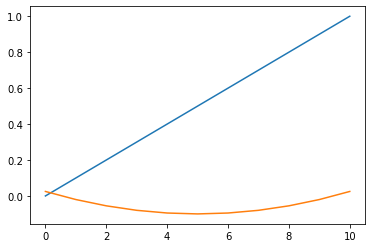

[10:43:42] Timestep 0 of 100000000000:
[10:43:42]   Non-linearity u-P solved in 5 steps.
[10:43:42]   ||u|| = 0.12222, ||u||_8 = 1.0, ||u-u_n|| = 0.12222, ||u-u_n||/||u|| = 1.0, div(u) = 1e-16
[10:43:42]   ||p|| = 0.1, ||p||_8 = 1.07524, ||p-p_n|| = 0.1, ||p-p_n||/||p|| = 1.0


Current mesh left profile has 17 vertexes, perimeter 1.0 and coordinates 
 {3: array([0., 0.]), 4: array([0.0625, 0.    ]), 48: array([0.125, 0.   ]), 29: array([0.1875, 0.    ]), 27: array([0.25, 0.  ]), 28: array([0.3125, 0.    ]), 53: array([0.375, 0.   ]), 13: array([0.4375, 0.    ]), 12: array([0.5, 0. ]), 14: array([0.5625, 0.    ]), 52: array([0.625, 0.   ]), 40: array([0.6875, 0.    ]), 39: array([0.75, 0.  ]), 41: array([0.8125, 0.    ]), 55: array([0.875, 0.   ]), 7: array([0.9375, 0.    ]), 6: array([1., 0.])}


Goal mesh left profile has 11 vertexes, perimeter 1.0016475910298237 and coordinates 
 [(0.0, 0.004999999999999999), (0.1, -0.003999999999999998), (0.2, -0.011000000000000003), (0.30000000000000004, -0.016000000000000004), (0.4, -0.019000000000000003), (0.5, -0.020000000000000004), (0.6000000000000001, -0.019000000000000003), (0.7000000000000001, -0.015999999999999997), (0.8, -0.011), (0.9, -0.003999999999999998), (1.0, 0.004999999999999999)]
old point [0. 0.] become

Current mesh left profile has 17 vertexes, perimeter 1.0 and coordinates 
 {3: array([0., 0.]), 4: array([0.0625, 0.    ]), 48: array([0.125, 0.   ]), 29: array([0.1875, 0.    ]), 27: array([0.25, 0.  ]), 28: array([0.3125, 0.    ]), 53: array([0.375, 0.   ]), 13: array([0.4375, 0.    ]), 12: array([0.5, 0. ]), 14: array([0.5625, 0.    ]), 52: array([0.625, 0.   ]), 40: array([0.6875, 0.    ]), 39: array([0.75, 0.  ]), 41: array([0.8125, 0.    ]), 55: array([0.875, 0.   ]), 7: array([0.9375, 0.    ]), 6: array([1., 0.])}


Goal mesh left profile has 11 vertexes, perimeter 1.0398559323862417 and coordinates 
 [(0.0, 0.024999999999999994), (0.1, -0.01999999999999999), (0.2, -0.05500000000000001), (0.30000000000000004, -0.08000000000000002), (0.4, -0.095), (0.5, -0.1), (0.6000000000000001, -0.095), (0.7000000000000001, -0.07999999999999999), (0.8, -0.05499999999999999), (0.9, -0.01999999999999999), (1.0, 0.024999999999999994)]
old point [0.   0.02] becomes (0.0, 0.024999999999999994)
old 

In [24]:
feffi.parameters.define_parameters({
    'config_file' : 'feffi/config/lid-driven-cavity.yml',
})
gif_filenames = []

# MESH INIT (unstructured)
points = [Point(0,0), Point(1,0), Point(1,1), Point(0,1)] # square
#points = [Point(0,0), Point(10,0), Point(10,1), Point(0,1)] # long domain
domain = Polygon(points)
mesh = generate_mesh(domain, 10, 'cgal')
#feffi.plot.plot_single(mesh, display=True, title="Starting mesh")

plot(mesh, title='Starting (ocean) mesh')
filename = 'mesh-1.png'
plt.savefig(filename, dpi=300)
plt.close()
for i in range(5):
    gif_filenames.append(filename)

# FEFFI INIT
f_spaces = feffi.functions.define_function_spaces(mesh)
f = feffi.functions.define_functions(f_spaces)
domain = feffi.boundaries.Domain(mesh, f_spaces)
simul = feffi.simulation.Simulation(f, domain.BCs)

# New "goal" left profile
# NOTE: goal profile is supposed to be COARSER than current profile
step_size = 0.1
goal_profile = [(x, 0.5*(x-0.5)**2-0.1)
                    for x in np.arange(min(mesh.coordinates()[:,0]), 
                                       max(mesh.coordinates()[:,0])+step_size, 
                                       step_size)]
plt.plot(goal_profile)
plt.show()
total_steps = 5
for i in range(total_steps):
    simul.timestep()
    
    def_coeff = (i+1)/total_steps
    goal_profile_now = [(x, def_coeff*y) 
                    for (x, y) in goal_profile]
    
    domain.deform_boundary('bottom', goal_profile_now)
    
    plot(mesh, title='{} (ocean) mesh'.format(i))
    filename = 'mesh{}.png'.format(i)
    plt.savefig(filename, dpi=300)
    plt.close()
    for i in range(3):
        gif_filenames.append(filename)

# build gif
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in gif_filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove files
#for filename in set(gif_filenames):
#    os.remove(filename)

## Projection and closest neighbors

In [49]:
import time
start=time.time()
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

ice_points = UnitSquareMesh(4,4).coordinates()
ocean_mesh = UnitSquareMesh(5,5)

#print(ice_points)

for p in ocean_mesh.coordinates():
    mask = np.ones(len(ice_points), dtype=bool)
    closest = closest_node(p, ice_points)
    mask[closest] = False
    #print(ice_points[mask])    
    second_closest = closest_node(p, ice_points[mask])
    
    P = np.array([ice_points[closest], ice_points[mask][second_closest]]) #P needs to be normalized to be a projector!
    proj = np.matmul(np.matmul(np.transpose(P), P), p)
    print(proj)
    
    print(('Node {}: 1st closest neighbor: {}; 2nd closest neighbor: {}, proj {}'
           .format(p, ice_points[closest], ice_points[mask][second_closest], proj)))
print('execution time {} seconds'.format(time.time()-start))

[0. 0.]
Node [0. 0.]: 1st closest neighbor: [0. 0.]; 2nd closest neighbor: [0.25 0.  ], proj [0. 0.]
[0.0125 0.    ]
Node [0.2 0. ]: 1st closest neighbor: [0.25 0.  ]; 2nd closest neighbor: [0. 0.], proj [0.0125 0.    ]
[0.125 0.   ]
Node [0.4 0. ]: 1st closest neighbor: [0.5 0. ]; 2nd closest neighbor: [0.25 0.  ], proj [0.125 0.   ]
[0.4875 0.    ]
Node [0.6 0. ]: 1st closest neighbor: [0.5 0. ]; 2nd closest neighbor: [0.75 0.  ], proj [0.4875 0.    ]
[1.25 0.  ]
Node [0.8 0. ]: 1st closest neighbor: [0.75 0.  ]; 2nd closest neighbor: [1. 0.], proj [1.25 0.  ]
[1.5625 0.    ]
Node [1. 0.]: 1st closest neighbor: [1. 0.]; 2nd closest neighbor: [0.75 0.  ], proj [1.5625 0.    ]
[0.     0.0125]
Node [0.  0.2]: 1st closest neighbor: [0.   0.25]; 2nd closest neighbor: [0. 0.], proj [0.     0.0125]
[0.0375 0.025 ]
Node [0.2 0.2]: 1st closest neighbor: [0.25 0.25]; 2nd closest neighbor: [0.25 0.  ], proj [0.0375 0.025 ]
[0.1625 0.1   ]
Node [0.4 0.2]: 1st closest neighbor: [0.5  0.25]; 2nd c

In [68]:
import time
start=time.time()
def closest_k_nodes(node, nodes, k):
    result = {}
    nodes = np.asarray(nodes)
    mask = np.ones(len(nodes), dtype=bool)
    distances = np.sum((nodes-node)**2, axis=1)
    
    closest_node_idx = -1
    max_dist = -1
    for _ in range(k):
        prev_closest_node_idx = closest_node_idx
        closest_node_idx = np.argmin(distances[mask])
        
        if prev_closest_node_idx > -1 and closest_node_idx >= prev_closest_node_idx:
            closest_node_idx += 1
        
        result[closest_node_idx] = {'coord': nodes[closest_node_idx], 'dist': distances[closest_node_idx]}
        mask[closest_node_idx] = False
    
    return result

ice_points = UnitSquareMesh(4,4).coordinates()
ocean_mesh = UnitSquareMesh(5,5)

for p in ocean_mesh.coordinates():
    mask = np.ones(len(ice_points), dtype=bool)
    closest = closest_k_nodes(p, ice_points, ocean_mesh.geometric_dimension())
    
    denom = 0
    avg = 0
    for entry in closest.values():
        if entry['dist'] == 0:
            continue
        
        denom += 1/entry['dist']
        avg += (1/entry['dist'])*entry['coord']
    
    new_p = avg/denom
    
    print('node {}, closest {}, avg {}'.format(p, closest, avg))
    
print('execution time {} seconds'.format(time.time()-start))

node [0. 0.], closest {0: {'coord': array([0., 0.]), 'dist': 0.0}, 1: {'coord': array([0.25, 0.  ]), 'dist': 0.0625}}, avg [0.25 0.  ]
node [0.2 0. ], closest {1: {'coord': array([0.25, 0.  ]), 'dist': 0.0024999999999999988}, 0: {'coord': array([0., 0.]), 'dist': 0.04000000000000001}}, avg [0.23529412 0.        ]
node [0.4 0. ], closest {2: {'coord': array([0.5, 0. ]), 'dist': 0.009999999999999995}, 1: {'coord': array([0.25, 0.  ]), 'dist': 0.022500000000000006}}, avg [0.42307692 0.        ]
node [0.6 0. ], closest {2: {'coord': array([0.5, 0. ]), 'dist': 0.009999999999999995}, 3: {'coord': array([0.75, 0.  ]), 'dist': 0.022500000000000006}}, avg [0.57692308 0.        ]
node [0.8 0. ], closest {3: {'coord': array([0.75, 0.  ]), 'dist': 0.0025000000000000044}, 4: {'coord': array([1., 0.]), 'dist': 0.03999999999999998}}, avg [0.76470588 0.        ]
node [1. 0.], closest {4: {'coord': array([1., 0.]), 'dist': 0.0}, 3: {'coord': array([0.75, 0.  ]), 'dist': 0.0625}}, avg [0.75 0.  ]
node [

## 3D

[11:28:43] BCs were only given for V, Q spaces.
[11:28:43] BCs - Boundary right, space V[0] (marker 1), value 0
[11:28:43] BCs - Boundary right, space V[1] (marker 1), value 0
[11:28:43] BCs - Boundary right, space V[2] (marker 1), value 0
[11:28:43] BCs - Boundary bottom, space V[0] (marker 3), value 0
[11:28:43] BCs - Boundary bottom, space V[1] (marker 3), value 0
[11:28:43] BCs - Boundary bottom, space V[2] (marker 3), value 0
[11:28:43] BCs - Boundary left, space V[0] (marker 2), value 0
[11:28:43] BCs - Boundary left, space V[1] (marker 2), value 0
[11:28:43] BCs - Boundary left, space V[2] (marker 2), value 0
[11:28:43] BCs - Boundary back, space V[0] (marker 5), value 0
[11:28:43] BCs - Boundary back, space V[1] (marker 5), value 0
[11:28:43] BCs - Boundary back, space V[2] (marker 5), value 0
[11:28:43] BCs - Boundary front, space V[0] (marker 4), value 0
[11:28:43] BCs - Boundary front, space V[1] (marker 4), value 0
[11:28:44] BCs - Boundary front, space V[2] (marker 4), val

[11:31:04] Point [0.         0.54432747 0.10423437] becomes [-0.01959345  0.54065462  0.1       ]
[11:31:04] Point [0.         0.45833333 0.11263195] becomes [-0.01963086  0.4630862   0.1       ]
[11:31:04] Point [0.         0.41666667 0.        ] becomes [-0.01908002  0.4080015   0.        ]
[11:31:04] Point [0.         0.66666667 0.        ] becomes [-0.01666445  0.67785178  0.        ]
[11:31:04] Point [0.         0.625      0.13517713] becomes [-0.01881839  0.60605362  0.12213029]
[11:31:04] Point [0.         0.375      0.16319748] becomes [-0.01845892  0.38196385  0.17379492]
[11:31:04] Point [0.         0.375      0.09135575] becomes [-0.01858638  0.38621258  0.09120069]
[11:31:04] Point [0.         0.50675975 0.16403153] becomes [-0.01991271  0.5087286   0.16601193]
[11:31:05] Point [0.         0.4333585  0.26120531] becomes [-0.0191809   0.41809025  0.25214964]
[11:31:05] Point [0.         0.29166667 0.11263195] becomes [-0.01574993  0.29499862  0.10545681]
[11:31:05] Point [0.

[11:31:05] Point [0. 1. 1.] becomes [0.00497765 0.99975164 0.99975186]
[11:31:05] Point [0.   1.   0.25] becomes [0.00417535 0.99083717 0.24541859]
[11:31:05] Point [0.         1.         0.33333333] becomes [0.00432247 0.99247194 0.31874183]
[11:31:05] Point [0.         1.         0.58333333] becomes [0.00475325 0.99725838 0.59595066]
[11:31:05] Point [0.  1.  0.5] becomes [0.00497765 0.99975164 0.49975186]
[11:31:05] Point [0.         1.         0.41666667] becomes [0.00475325 0.99725838 0.40404934]
[11:31:05] Deformed boundary left.


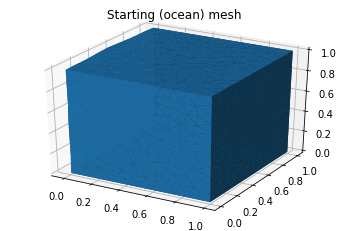

[11:31:07] Solving for dph/dx...
[11:31:08] Solved for dph/dx.
[11:31:08] Interpolated dph/dx over 2D grid (norm = 0.0).
[11:31:08] Iteratively solving non-linear problem
[11:31:09] Solving for u, p...
[11:31:18] Solved for u, p.
[11:31:32] >>> residual u: 0.05375909253550831 <<<
[11:31:32] Solving for u, p...
[11:31:42] Solved for u, p.
[11:31:57] >>> residual u: 0.007404564719477429 <<<
[11:31:58] Solving for u, p...
[11:32:10] Solved for u, p.
[11:32:25] >>> residual u: 0.0012154850118125493 <<<
[11:32:25] Solving for u, p...
[11:32:35] Solved for u, p.
[11:32:51] >>> residual u: 0.00024348970350190102 <<<
[11:32:51] Solving for u, p...
[11:33:02] Solved for u, p.
[11:33:19] >>> residual u: 5.1700081180578207e-05 <<<
[11:33:19] Solving for u, p...
[11:33:31] Solved for u, p.
[11:33:44] >>> residual u: 1.0854944328601342e-05 <<<
[11:33:44] Solving for u, p...
[11:33:56] Solved for u, p.
[11:34:09] >>> residual u: 2.2679880574528826e-06 <<<
[11:34:09] Solved non-linear problem.
[11:34

[11:34:26] Point [0.         0.43718819 0.37520787] becomes [-0.03856883  0.42844149  0.37934752]
[11:34:26] Point [0.         0.50675757 0.30155967] becomes [-0.03972039  0.51398034  0.3       ]
[11:34:26] Point [0.         0.54166667 0.22541998] becomes [-0.03915943  0.54202835  0.2       ]
[11:34:26] Point [0.         0.45833333 0.89103412] becomes [-0.03930218  0.46510903  0.8852096 ]
[11:34:26] Point [0.         0.79662265 0.45137935] becomes [-0.02305172  0.7894828   0.45731758]
[11:34:26] Point [0.         0.70058597 0.375     ] becomes [-0.03123671  0.70763292  0.37400935]
[11:34:26] Point [0.         0.71157274 0.48201028] becomes [-0.03123374  0.70766256  0.47772977]
[11:34:26] Point [0.         0.84497487 0.375     ] becomes [-0.01670474  0.83782328  0.38271216]
[11:34:26] Point [0.         0.80108824 0.54166667] becomes [-0.02136832  0.80451202  0.53020693]
[11:34:26] Point [0.         0.89914038 0.45833333] becomes [-0.00656434  0.90797591  0.46056812]
[11:34:26] Point [0.

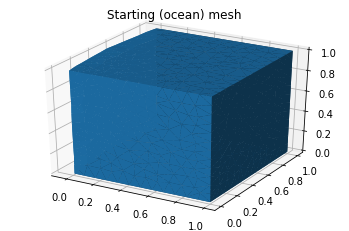

[11:34:29] Solving for dph/dx...
[11:34:29] Solved for dph/dx.
[11:34:30] Interpolated dph/dx over 2D grid (norm = 0.0).
[11:34:30] Iteratively solving non-linear problem
[11:34:30] Solving for u, p...
[11:34:38] Solved for u, p.
[11:34:57] >>> residual u: 0.029516009424952836 <<<
[11:34:57] Solving for u, p...
[11:35:06] Solved for u, p.
[11:35:14] >>> residual u: 0.004956124407361111 <<<
[11:35:14] Solving for u, p...
[11:35:19] Solved for u, p.
[11:35:30] >>> residual u: 0.0010821895702723611 <<<
[11:35:30] Solving for u, p...
[11:35:39] Solved for u, p.
[11:35:55] >>> residual u: 0.00027401224346635116 <<<
[11:35:55] Solving for u, p...
[11:36:05] Solved for u, p.
[11:36:21] >>> residual u: 8.951536743478756e-05 <<<
[11:36:21] Solving for u, p...
[11:36:31] Solved for u, p.
[11:36:46] >>> residual u: 2.9200435580120805e-05 <<<
[11:36:46] Solving for u, p...
[11:36:59] Solved for u, p.
[11:37:18] >>> residual u: 9.521753468159066e-06 <<<
[11:37:18] Solved non-linear problem.
[11:37:

[11:37:30] Point [0.         0.43718819 0.37520787] becomes [-0.05789594  0.42986479  0.37631304]
[11:37:30] Point [0.         0.50675757 0.30155967] becomes [-0.05929816  0.52339471  0.3       ]
[11:37:30] Point [0.         0.54166667 0.22541998] becomes [-0.0586486   0.54504653  0.2       ]
[11:37:30] Point [0.         0.45833333 0.89103412] becomes [-0.05890394  0.46346451  0.88194545]
[11:37:30] Point [0.         0.79662265 0.45137935] becomes [-0.03052648  0.81177868  0.44579968]
[11:37:30] Point [0.         0.70058597 0.375     ] becomes [-0.04628747  0.71141689  0.36468608]
[11:37:30] Point [0.         0.71157274 0.48201028] becomes [-0.04620733  0.71195111  0.46765907]
[11:37:30] Point [0.         0.84497487 0.375     ] becomes [-0.0244308   0.84080569  0.38226688]
[11:37:30] Point [0.         0.80108824 0.54166667] becomes [-0.03185183  0.80546748  0.53103579]
[11:37:30] Point [0.         0.89914038 0.45833333] becomes [-0.00979186  0.90817828  0.46000683]
[11:37:30] Point [0.

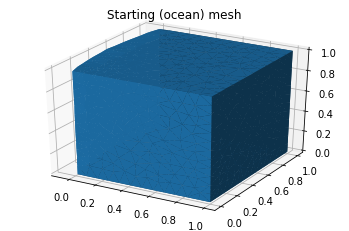

[11:37:31] Solving for dph/dx...
[11:37:31] Solved for dph/dx.
[11:37:32] Interpolated dph/dx over 2D grid (norm = 0.0).
[11:37:32] Iteratively solving non-linear problem
[11:37:32] Solving for u, p...
[11:37:39] Solved for u, p.
[11:37:55] >>> residual u: 0.02856330138894815 <<<
[11:37:55] Solving for u, p...
[11:38:04] Solved for u, p.
[11:38:18] >>> residual u: 0.0079980638693896 <<<
[11:38:18] Solving for u, p...
[11:38:26] Solved for u, p.
[11:38:41] >>> residual u: 0.0024858481150427003 <<<
[11:38:41] Solving for u, p...
[11:38:51] Solved for u, p.
[11:39:05] >>> residual u: 0.0007186853093441519 <<<
[11:39:05] Solving for u, p...
[11:39:15] Solved for u, p.
[11:39:30] >>> residual u: 0.0003131517881080519 <<<
[11:39:30] Solving for u, p...
[11:39:39] Solved for u, p.
[11:39:46] >>> residual u: 0.00014403821394181308 <<<
[11:39:46] Solving for u, p...
[11:39:56] Solved for u, p.
[11:40:11] >>> residual u: 6.843349143332216e-05 <<<
[11:40:11] Solving for u, p...
[11:40:20] Solved 

[11:41:01] Point [0.         0.09135575 0.375     ] becomes [-0.01309172  0.09192143  0.38728899]
[11:41:01] Point [0.         0.11263195 0.45833333] becomes [-0.01868558  0.10959137  0.45782412]
[11:41:01] Point [0.         0.41441008 0.46267378] becomes [-0.07677307  0.41932667  0.44625061]
[11:41:01] Point [0.         0.43718819 0.37520787] becomes [-0.07722507  0.43062667  0.37380705]
[11:41:01] Point [0.         0.50675757 0.30155967] becomes [-0.07876713  0.53082164  0.3       ]
[11:41:01] Point [0.         0.54166667 0.22541998] becomes [-0.07811207  0.54719822  0.2       ]
[11:41:01] Point [0.         0.45833333 0.89103412] becomes [-0.07851339  0.46283468  0.87904688]
[11:41:01] Point [0.         0.79662265 0.45137935] becomes [-0.04006267  0.8140619   0.44430115]
[11:41:01] Point [0.         0.70058597 0.375     ] becomes [-0.06091794  0.71541031  0.35693715]
[11:41:01] Point [0.         0.71157274 0.48201028] becomes [-0.05916139  0.72419303  0.47774275]
[11:41:01] Point [0.

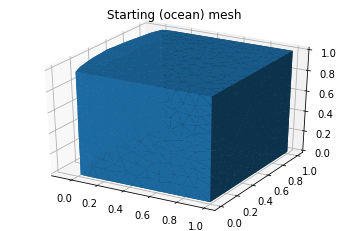

[11:41:02] Solving for dph/dx...
[11:41:02] Solved for dph/dx.
[11:41:02] Interpolated dph/dx over 2D grid (norm = 0.0).
[11:41:02] Iteratively solving non-linear problem
[11:41:02] Solving for u, p...
[11:41:08] Solved for u, p.
[11:41:15] >>> residual u: 0.028199513122786454 <<<
[11:41:15] Solving for u, p...
[11:41:20] Solved for u, p.
[11:41:27] >>> residual u: 0.01023053066089821 <<<
[11:41:27] Solving for u, p...
[11:41:32] Solved for u, p.
[11:41:39] >>> residual u: 0.003753415765231429 <<<
[11:41:39] Solving for u, p...
[11:41:45] Solved for u, p.
[11:41:52] >>> residual u: 0.001335176780501958 <<<
[11:41:52] Solving for u, p...
[11:41:57] Solved for u, p.
[11:42:04] >>> residual u: 0.0006236939510534382 <<<
[11:42:04] Solving for u, p...
[11:42:10] Solved for u, p.
[11:42:17] >>> residual u: 0.00035823658183906115 <<<
[11:42:17] Solving for u, p...
[11:42:22] Solved for u, p.
[11:42:29] >>> residual u: 0.00024179523167577855 <<<
[11:42:30] Solving for u, p...
[11:42:35] Solved

[11:44:30] Point [0.         0.29166667 0.11263195] becomes [-0.07090239  0.26360957  0.1       ]
[11:44:30] Point [0.         0.         0.91666667] becomes [0.02353749 0.00325002 0.9070594 ]
[11:44:30] Point [0.         0.         0.83333333] becomes [0.02302534 0.00438813 0.82000265]
[11:44:30] Point [0.         0.33333333 0.        ] becomes [-0.08537005  0.33580034  0.        ]
[11:44:30] Point [0.   0.25 0.  ] becomes [-0.06457539  0.23830156  0.        ]
[11:44:30] Point [0.         0.16319748 0.375     ] becomes [-0.04102553  0.16007293  0.37996978]
[11:44:30] Point [0.         0.20101622 0.45478419] becomes [-0.04874233  0.18212095  0.46247969]
[11:44:30] Point [0.         0.09135575 0.375     ] becomes [-0.01601731  0.09114957  0.38607681]
[11:44:30] Point [0.         0.11263195 0.45833333] becomes [-0.02327911  0.1093689   0.45738421]
[11:44:30] Point [0.         0.41441008 0.46267378] becomes [-0.0960834   0.42166795  0.44333966]
[11:44:30] Point [0.         0.43718819 0.37

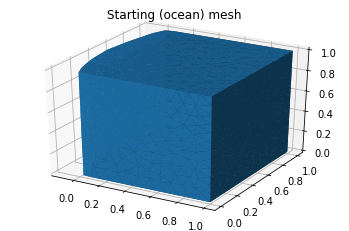

In [2]:
feffi.parameters.define_parameters({
    'config_file' : 'feffi/config/lid-driven-cavity-3D.yml',
    'very_verbose' : True
})
gif_filenames = []

# MESH INIT (unstructured)
points = [(0,0), (1,0), (1,1), (0, 1)]
Points = [Point(p) for p in points]
g2d = mshr.Polygon(Points)
g3d = mshr.Extrude2D(g2d, 1)
mesh = mshr.generate_mesh(g3d, 20)

plot(mesh, title='Starting (ocean) mesh')
filename = 'mesh-1.png'
plt.savefig(filename, dpi=300)
plt.close()
for i in range(5):
    gif_filenames.append(filename)

# FEFFI INIT
f_spaces = feffi.functions.define_function_spaces(mesh)
f = feffi.functions.define_functions(f_spaces)
domain = feffi.boundaries.Domain(mesh, f_spaces)
simul = feffi.simulation.Simulation(f, domain.BCs)

# New "goal" left profile
# NOTE: goal profile is supposed to be COARSER than current profile
step_size = 0.1
goal_profile = np.array([(0.5*(y-0.5)**2-0.1, y, z)
                    for y in np.arange(min(mesh.coordinates()[:,1]),
                                       max(mesh.coordinates()[:,1])+step_size,
                                       step_size)
                    for z in np.arange(min(mesh.coordinates()[:,2]),
                                       max(mesh.coordinates()[:,2])+step_size,
                                       step_size)])

total_steps = 5
for i in range(total_steps):
    simul.timestep()
    
    def_coeff = (i+1)/total_steps
    goal_profile_now = [(def_coeff*x, y, z) 
                    for (x, y, z) in goal_profile]
    
    domain.deform_boundary('left', goal_profile_now)
    plot(mesh, title='Starting (ocean) mesh')
    plt.show()
    plt.close()
    
    plot(mesh, title='{} (ocean) mesh'.format(i))
    filename = 'mesh{}.png'.format(i)
    plt.savefig(filename, dpi=300)
    plt.close()
    for i in range(3):
        gif_filenames.append(filename)

# build gif
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in gif_filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove files
#for filename in set(gif_filenames):
#    os.remove(filename)